## Import & 전처리

In [17]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

In [3]:
Env = pd.read_csv("./environment_tocken.csv", encoding='utf-8-sig')
Env.head()

,Unnamed: 0,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자,법률안,제안정당,법률공포여부,텍스트,토큰,명사수
0,0,2000042,처,해양환경관리법 일부개정법률안,의원,2016-05-30,2016-12-08 00:00:00,대안반영폐기,NaN,의안원문\r\n비용추계서 미첨부 사유서,제20대 (2016~2020) 제342회,최근 국제해사기구(IMO)의 온실가스 유해물질 평형수 등의 환경 관련 규제가 순차적...,농림축산식품해양수산위원회,"[""['김성찬(새누리당/金盛贊)'"", "" '경대수(새누리당/慶大秀)'"", "" '김재...",1.0,"['더불어민주당', '새누리당']",미공포,해양환경관리법 일부개정법률안 최근 국제해사기구의 온실가스 유해물질 평형수 등의 ...,"['해양', '환경', '관리', '일부', '개정', '법률', '최근', '국제...",83
1,1,2000043,처,공직선거법 일부개정법률안,의원,2016-05-30,2020-05-29 00:00:00,임기만료폐기,NaN,의안원문\r\n비용추계서,제20대 (2016~2020) 제342회,현행법은 19세 이상의 국민에게 대통령선거ㆍ국회의원선거ㆍ지방의회의원선거 및 지방자치...,행정안전위원회,"[""['윤후덕(더불어민주당/尹厚德)'"", "" '김경협(더불어민주당/金炅俠)'"", ""...",1.0,"['더불어민주당', '새누리당']",미공포,공직선거법 일부개정법률안 현행법은 세 이상의 국민에게 대통령선거국회의원선거지방의...,"['공직선거법', '일부', '개정', '법률', '현행법', '이상', '국민',...",69
2,2,2000010,처,환경친화적 자동차의 개발 및 보급 촉진에 관한 법률 일부개정법률안,의원,2016-05-30,2016-11-17 00:00:00,수정가결,NaN,의안원문,제20대 (2016~2020) 제342회,현행법은 환경친화적 자동차의 개발 및 보급을 촉진하기 위하여 해당 자동차에 대해서는...,산업통상자원위원회,"[""['이찬열(더불어민주당/李燦烈)'"", "" '김현미(더불어민주당/金賢美)'"", ""...",1.0,"['더불어민주당', '국민의당']",공포,환경친화적 자동차의 개발 및 보급 촉진에 관한 법률 일부개정법률안 현행법은 환경...,"['환경', '자동차', '개발', '보급', '촉진', '법률', '일부', '개...",188
3,3,2000019,처,국가재정법 일부개정법률안,의원,2016-05-30,2020-05-29 00:00:00,임기만료폐기,NaN,의안원문,제20대 (2016~2020) 제342회,경상북도 울릉도ㆍ독도 지역은 동해 유일의 접경지역으로서 군사적ㆍ국가 안보적 차원에서...,기획재정위원회,"[""['박명재(새누리당/朴明在)'"", "" '강석호(새누리당/姜碩鎬)'"", "" '경대...",1.0,"['무소속', '새누리당']",미공포,국가재정법 일부개정법률안 경상북도 울릉도독도 지역은 동해 유일의 접경지역으로서 ...,"['국가', '정법', '일부', '개정', '법률', '경상북도', '울릉도', ...",148
4,4,2000062,처,유통산업발전법 일부개정법률안,의원,2016-05-31,2020-05-29 00:00:00,임기만료폐기,NaN,의안원문,제20대 (2016~2020) 제342회,현행법은 대기업의 지역상권 진출로부터 전통시장과 골목상권을 보호하기 위하여 대규모점...,산업통상자원중소벤처기업위원회,"[""['조경태(새누리당/趙慶泰)'"", "" '김재경(새누리당/金在庚)'"", "" '민홍...",1.0,"['더불어민주당', '새누리당', '국민의당']",미공포,유통산업발전법 일부개정법률안 현행법은 대기업의 지역상권 진출로부터 전통시장과 골...,"['유통', '산업', '발전', '일부', '개정', '법률', '현행법', '대...",98


In [4]:
# 명사 수가 50개를 넘어가는 경우만 추출

env = Env[Env['명사수'] >= 50]
env = env.reset_index(drop=True)

# ['토큰'] 칼럼 콤마 기준 스플릿

for i in range(len(env)):

    env_tocken=[]

    env['토큰'][i] = env['토큰'][i][1:-1].split(', ')
    for j in env['토큰'][i]:
        env_tocken.append(j[1:-1])

    env['토큰'][i] = env_tocken

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [5]:
env['토큰']

0       [해양, 환경, 관리, 일부, 개정, 법률, 최근, 국제, 기구, 온실가스, 유해,...
1       [공직선거법, 일부, 개정, 법률, 현행법, 이상, 국민, 대통령선거, 국회의원선거...
2       [환경, 자동차, 개발, 보급, 촉진, 법률, 일부, 개정, 법률, 현행법, 환경,...
3       [국가, 정법, 일부, 개정, 법률, 경상북도, 울릉도, 독도, 지역, 동해, 유일...
4       [유통, 산업, 발전, 일부, 개정, 법률, 현행법, 대기업, 지역, 상권, 진출,...
                              ...                        
2898    [도시, 주거, 환경, 비법, 일부, 개정, 법률, 현행법, 사업, 시행, 정비, ...
2899    [공중화장실, 법률, 일부, 개정, 법률, 현행법, 국민, 위생, 상의, 편의, 복...
2900    [어린이, 시설, 안전, 관리, 일부, 개정, 법률, 유엔, 아동권리, 협약, 제조...
2901    [어린이, 시설, 안전, 관리, 일부, 개정, 법률, 유엔, 아동권리, 협약, 제조...
2902    [공중화장실, 법률, 일부, 개정, 법률, 현행법, 국민, 위생, 상의, 편의, 복...
Name: 토큰, Length: 2903, dtype: object

In [6]:
# 의미없는 단어 삭제 
#def remove_stopword(text): 
#    stopwords = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음’,’정책','일부','개정','최근',
#                '집단','국내','의거','거나','함안','시행','이하','기한', '위해', '장관', '특별법', '마련','제호','임안','조사','운영','기관', '또한', '포함', '내용', 
#                 '명시', '촉진', '근거', '실시', '지정', '현행', '의무', '확인', '도지사', '대통령령', '업무', '제출','대해']
#    text = [word for word in text if word not in stopwords]
#    return text

#for i in range(len(env)):
#    env['토큰'][i] = remove_stopword(env['토큰'][i])

In [7]:
env['토큰']

0       [해양, 환경, 관리, 일부, 개정, 법률, 최근, 국제, 기구, 온실가스, 유해,...
1       [공직선거법, 일부, 개정, 법률, 현행법, 이상, 국민, 대통령선거, 국회의원선거...
2       [환경, 자동차, 개발, 보급, 촉진, 법률, 일부, 개정, 법률, 현행법, 환경,...
3       [국가, 정법, 일부, 개정, 법률, 경상북도, 울릉도, 독도, 지역, 동해, 유일...
4       [유통, 산업, 발전, 일부, 개정, 법률, 현행법, 대기업, 지역, 상권, 진출,...
                              ...                        
2898    [도시, 주거, 환경, 비법, 일부, 개정, 법률, 현행법, 사업, 시행, 정비, ...
2899    [공중화장실, 법률, 일부, 개정, 법률, 현행법, 국민, 위생, 상의, 편의, 복...
2900    [어린이, 시설, 안전, 관리, 일부, 개정, 법률, 유엔, 아동권리, 협약, 제조...
2901    [어린이, 시설, 안전, 관리, 일부, 개정, 법률, 유엔, 아동권리, 협약, 제조...
2902    [공중화장실, 법률, 일부, 개정, 법률, 현행법, 국민, 위생, 상의, 편의, 복...
Name: 토큰, Length: 2903, dtype: object

In [9]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(env['토큰'], size=300, window = 10, min_count=50, workers=4, iter=100, sg=1)

#### 모델생성
model = gensim.models.Word2Vec.load('./ko/ko.bin')

In [8]:
# 문장 벡터 생성

def get_sentence_mean_vector(morphs):

    vector = []

    for i in morphs:

        try:
            vector.append(model.wv[i])
        except:
            pass


    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
    
    

# 엘보우 함수

def elbow(X):
    
    sse = []
    
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [10]:
# 문장 벡터 생성

env['문장벡터'] = env['토큰'].map(get_sentence_mean_vector)

In [11]:
env['문장벡터'][0]

array([ 0.04680072,  0.05733576, -0.17012899,  0.1830553 , -0.04733862,
        0.15218928, -0.10038402, -0.15435573,  0.06942134, -0.06779934,
       -0.07659684,  0.08062403, -0.05321339, -0.01503462, -0.11978269,
       -0.15281542, -0.01006646,  0.141124  , -0.05075305, -0.09140171,
        0.1078949 ,  0.11787476, -0.01752415, -0.08373832, -0.11702242,
        0.09088697,  0.12244142,  0.09754474, -0.03409018,  0.01302739,
        0.07481857,  0.05525205, -0.02662272,  0.1555121 , -0.05279403,
       -0.03087166,  0.01814658, -0.11042885, -0.15478171, -0.03253056,
        0.08988663, -0.10078753, -0.11821397,  0.01145588, -0.00526415,
        0.17879032, -0.0353242 , -0.16733381,  0.06665175,  0.10626892,
        0.07216223, -0.03269701,  0.10993633, -0.06833054,  0.06423023,
       -0.1264519 , -0.01805011,  0.05317686, -0.00904895,  0.0529145 ,
        0.08186676,  0.06918211, -0.01964807, -0.09058286,  0.04744016,
        0.01951602, -0.01466972, -0.12324454, -0.0340955 ,  0.03

env.to_csv("environment_wv.csv", encoding="utf-8-sig")

## 일단 시각화

In [13]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(env['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=env['의안명'], columns=["x", "y"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2903 samples in 0.031s...
[t-SNE] Computed neighbors for 2903 samples in 3.377s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2903
[t-SNE] Computed conditional probabilities for sample 2000 / 2903
[t-SNE] Computed conditional probabilities for sample 2903 / 2903
[t-SNE] Mean sigma: 0.425747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.882568
[t-SNE] KL divergence after 300 iterations: 1.891290


In [14]:
tsne_df.head()

,x,y
의안명,,
해양환경관리법 일부개정법률안,1.436843,-9.689598
공직선거법 일부개정법률안,4.064236,14.586735
환경친화적 자동차의 개발 및 보급 촉진에 관한 법률 일부개정법률안,-1.030715,-12.383945
국가재정법 일부개정법률안,-6.560388,-9.114177
유통산업발전법 일부개정법률안,10.520590,-1.525302


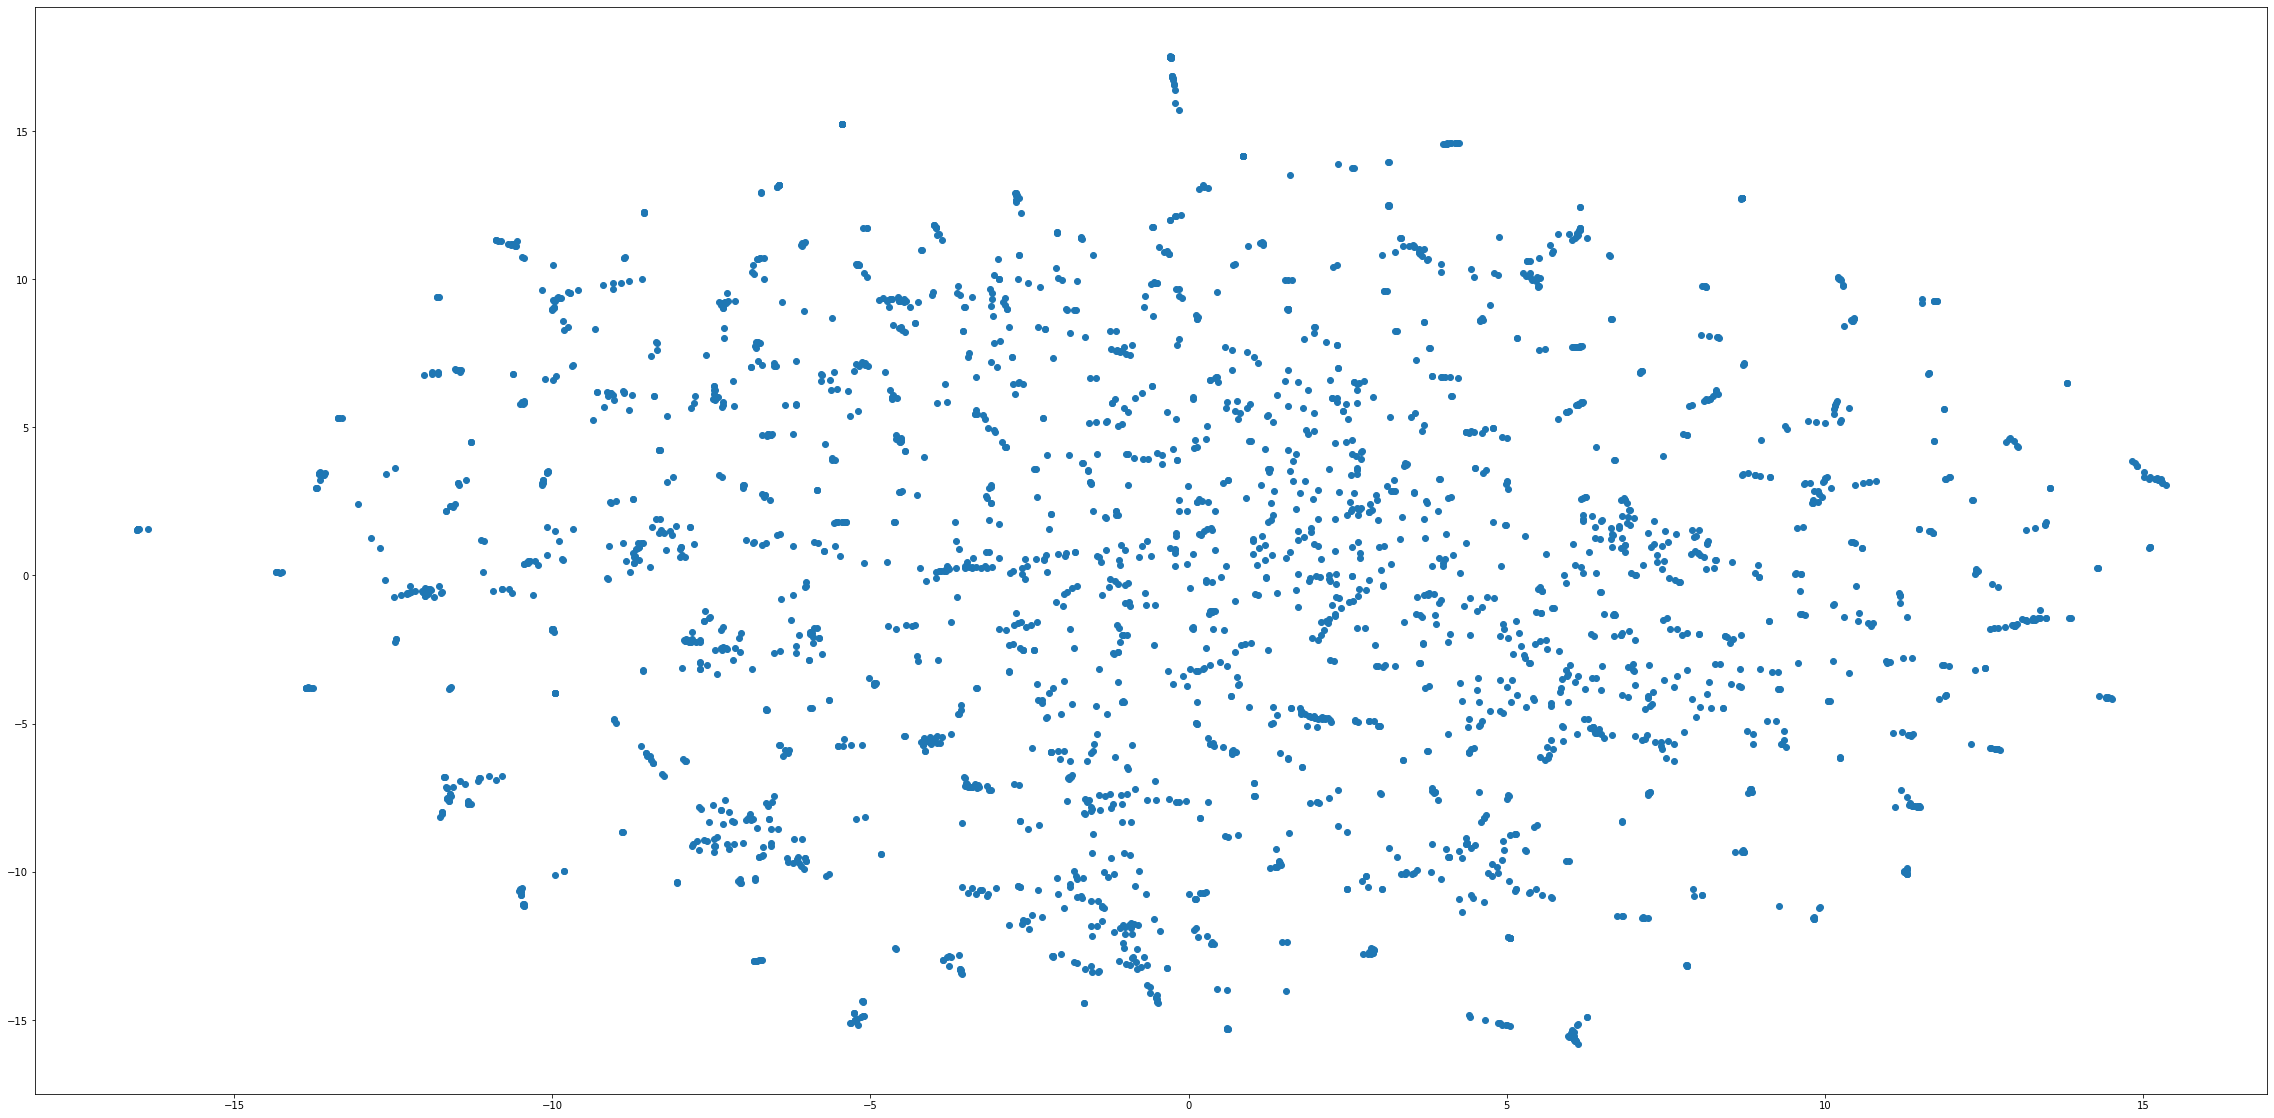

In [16]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:14<00:00,  1.01s/it]


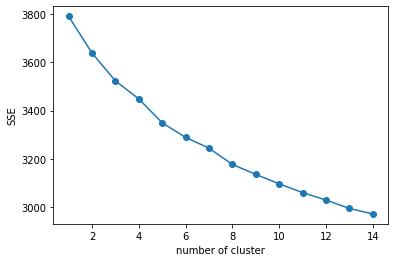

In [97]:
# 엘보우 함수로 군집 개수 결정

word_vectors = env.문장벡터.to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [23]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()


## GMM

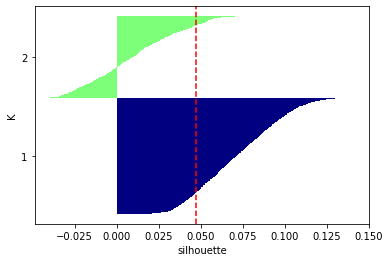

In [27]:
word_vectors = env.문장벡터.to_list()
k= 2

#X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
#                  shuffle=True, random_state=0)


km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)

plotSilhouette(word_vectors, y_km)

## KMeans

#### 군집수 = 2일 때 

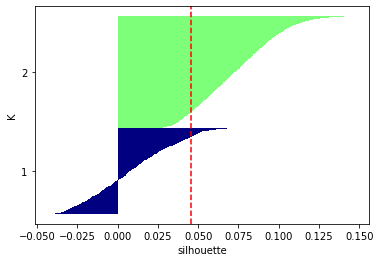

In [99]:
word_vectors = env.문장벡터.to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집수 = 3일 때

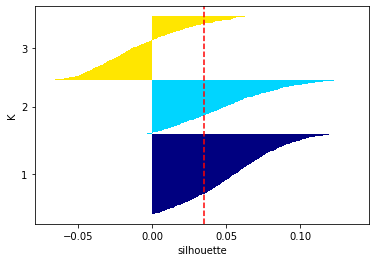

In [100]:
word_vectors = env.문장벡터.to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집수 = 4일 때

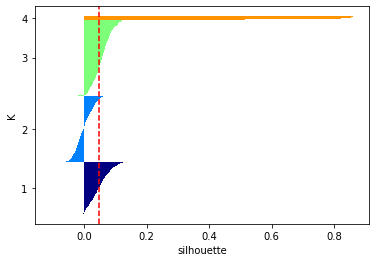

In [101]:
word_vectors = env.문장벡터.to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집수 = 5일 때

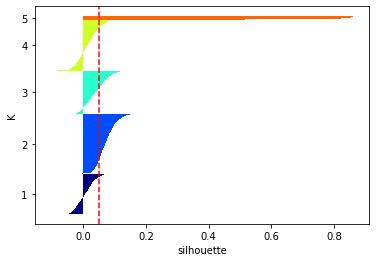

In [102]:
word_vectors = env.문장벡터.to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집수 = 6일 때

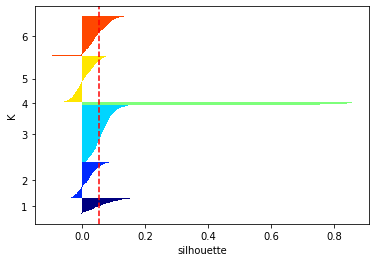

In [103]:
word_vectors = env.문장벡터.to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행 - 군집 3개


In [28]:
# K means 수행 

word_vectors = env.문장벡터.to_list()
num_clusters = 3

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
env['category'] = idx

In [29]:
env.category.value_counts()

0    1179
2     922
1     802
Name: category, dtype: int64

In [30]:
from sklearn.manifold import TSNE

X = env['문장벡터'].to_list()
y = env['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = env['의안번호'].to_list()
tsne_df['BillName'] = env['의안명'].to_list()
tsne_df['cluster_no'] = y

In [31]:
tsne_df.head()

,x_coord,y_coord,BillNo,BillName,cluster_no
0,-18.470873,47.290955,2000042,해양환경관리법 일부개정법률안,0
1,-19.216970,-34.597073,2000043,공직선거법 일부개정법률안,2
2,26.469704,54.909355,2000010,환경친화적 자동차의 개발 및 보급 촉진에 관한 법률 일부개정법률안,1
3,50.990898,4.568211,2000019,국가재정법 일부개정법률안,0
4,-16.969378,14.632090,2000062,유통산업발전법 일부개정법률안,0


tsne_df.to_csv("kmeans_3clusters.csv", encoding="utf-8-sig")

In [32]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [33]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]

colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}

colors = [colormap[x] for x in tsne_df['cluster_no']]

tsne_df['color'] = colors

In [34]:
# Bokeh가 인식하는 DataSource 객체 만들어주기

plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)

tsne_plot = figure(
    title='Bills about Environment',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [35]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)

## KMeans 수행 - 군집 4개

In [36]:
# K means 수행 

word_vectors = env.문장벡터.to_list()
num_clusters = 4

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
env['category'] = idx

In [37]:
env.category.value_counts()

0    940
3    764
1    658
2    541
Name: category, dtype: int64

In [38]:
from sklearn.manifold import TSNE

X = env['문장벡터'].to_list()
y = env['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = env['의안번호'].to_list()
tsne_df['BillName'] = env['의안명'].to_list()
tsne_df['cluster_no'] = y

In [39]:
tsne_df.head()

,x_coord,y_coord,BillNo,BillName,cluster_no
0,-18.470873,47.290955,2000042,해양환경관리법 일부개정법률안,1
1,-19.216970,-34.597073,2000043,공직선거법 일부개정법률안,3
2,26.469704,54.909355,2000010,환경친화적 자동차의 개발 및 보급 촉진에 관한 법률 일부개정법률안,1
3,50.990898,4.568211,2000019,국가재정법 일부개정법률안,0
4,-16.969378,14.632090,2000062,유통산업발전법 일부개정법률안,2


tsne_df.to_csv("kmeans_4clusters.csv", encoding="utf-8-sig")

In [40]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [41]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]

colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}

colors = [colormap[x] for x in tsne_df['cluster_no']]

tsne_df['color'] = colors

In [42]:
# Bokeh가 인식하는 DataSource 객체 만들어주기

plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)

tsne_plot = figure(
    title='Bills about Environment',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [43]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)